# Homework - Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Your homework contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [9]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
!wget --no-check-certificate "https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py" -O tiny_img.py
!wget --no-check-certificate "https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py" -O tiny_img_dataset.py

--2023-09-21 01:27:06--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 813 [text/plain]
Сохранение в: ‘tiny_img.py’

tiny_img.py         100%[===================>]     813  --.-KB/s    за 0s      

2023-09-21 01:27:07 (119 MB/s) - ‘tiny_img.py’ сохранён [813/813]

--2023-09-21 01:27:07--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP

In [10]:
#!L
from tiny_img import download_tinyImg200
# data_path = '.'

data_path = '/home/aksel/Документы/deep_vision_and_graphics/homework01/'
download_tinyImg200(data_path)

Dataset was downloaded to '/home/aksel/Документы/deep_vision_and_graphics/homework01/tiny-imagenet-200.zip'
Extract downloaded dataset to '/home/aksel/Документы/deep_vision_and_graphics/homework01/'


## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [1]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [2]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     # YOUR CODE : examine torchvision.transforms package, find transformation for color jittering
     # and add it with proper parameters.
     # transforms.SOME_OTHER_AUGMENTATION_FOR_COLOR_JITTER
     transforms.ColorJitter()
     # you may add any other transforms here
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [3]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset 
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|████████████████| 200/200 [00:14<00:00, 13.55it/s]


Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = sorted(list({class_label for _, class_label in annotations}))
        
        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image = tiny_img_dataset.read_rgb_image(img_name)

            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets", 
        # transform the image using self.transform and return the transformed image and its target label
        
        # YOUR CODE
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [5]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|████████████| 10000/10000 [00:01<00:00, 6725.47it/s]


For the most cases the default `DataLoader` will be good enough.

In [6]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=12)

In [7]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=12)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters. 

In [8]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [9]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

    
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()
        
        # YOUR CODE: define vars for convolution, batchnorm, relu
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        # self.relu = nn.CELU()
        # self.relu = nn.RReLU(0.1, 0.3)
        # self.relu = nn.Sigmoid()
        
    def forward(self, x):
        # YOUR CODE: sequentially apply convolution, batchnorm, relu to 'x'
        x = self.relu(self.bn(self.conv(x)))
        return x
    
    
def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()
    
    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config
    
    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            
            # YOUR CODE: add ConvBNRelu module to model
            model.add_module(f'ConvBNRelu_{block_index}_{layer_index_in_block}', ConvBNRelu(in_channels, out_channels, kernel_size=3))
            
            in_channels = out_channels
            
        if block_index != len(config) - 1:
            # model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))
            # model.add_module(f'mp_{block_index}', nn.AvgPool2d(3, stride=2))
            model.add_module(f'mp_{block_index}', nn.LPPool2d(2, 3, stride=2))
            
            
    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

In [10]:
model = create_vgg_like_network()
model = model.to(device)

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [10]:
#!L
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters. 

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

In [13]:
opt = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 30, 0.00001, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


### 1.5 Training loop

Let's combine the previously defined things together.

In [11]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()
    
        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch, 
        # run `compute_loss()` function
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)
        
        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        val_accuracy = eval_model(model, val_data_generator)
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))
        
def train_loop(model, optimizer, scheduler, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        val_accuracy = eval_model(model, val_data_generator)
        scheduler.step()
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here. 

In [25]:
# basic part with maxpooling

train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.93it/s]


Epoch 1 of 30 took 20.550s
  training loss (in-iteration): 	4.216473
  validation accuracy: 			12.39 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.92it/s]


Epoch 2 of 30 took 20.549s
  training loss (in-iteration): 	3.532163
  validation accuracy: 			22.81 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.02it/s]


Epoch 3 of 30 took 20.598s
  training loss (in-iteration): 	3.228299
  validation accuracy: 			25.73 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.00it/s]


Epoch 4 of 30 took 20.561s
  training loss (in-iteration): 	3.025477
  validation accuracy: 			29.04 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.84it/s]


Epoch 5 of 30 took 20.604s
  training loss (in-iteration): 	2.875968
  validation accuracy: 			30.95 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.79it/s]


Epoch 6 of 30 took 20.584s
  training loss (in-iteration): 	2.763557
  validation accuracy: 			31.53 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.72it/s]


Epoch 7 of 30 took 20.617s
  training loss (in-iteration): 	2.674122
  validation accuracy: 			33.85 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.71it/s]


Epoch 8 of 30 took 20.631s
  training loss (in-iteration): 	2.593081
  validation accuracy: 			34.50 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.09it/s]


Epoch 9 of 30 took 20.548s
  training loss (in-iteration): 	2.527864
  validation accuracy: 			35.26 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.97it/s]


Epoch 10 of 30 took 20.556s
  training loss (in-iteration): 	2.467955
  validation accuracy: 			35.68 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.00it/s]


Epoch 11 of 30 took 20.546s
  training loss (in-iteration): 	2.416592
  validation accuracy: 			37.62 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.88it/s]


Epoch 12 of 30 took 20.579s
  training loss (in-iteration): 	2.370392
  validation accuracy: 			38.78 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.82it/s]


Epoch 13 of 30 took 20.611s
  training loss (in-iteration): 	2.324055
  validation accuracy: 			36.97 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.92it/s]


Epoch 14 of 30 took 20.596s
  training loss (in-iteration): 	2.287367
  validation accuracy: 			39.44 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.05it/s]


Epoch 15 of 30 took 20.557s
  training loss (in-iteration): 	2.250890
  validation accuracy: 			39.70 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.02it/s]


Epoch 16 of 30 took 20.515s
  training loss (in-iteration): 	2.216917
  validation accuracy: 			40.69 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.10it/s]


Epoch 17 of 30 took 20.548s
  training loss (in-iteration): 	2.186918
  validation accuracy: 			40.29 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.27it/s]


Epoch 18 of 30 took 20.497s
  training loss (in-iteration): 	2.157252
  validation accuracy: 			41.24 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.12it/s]


Epoch 19 of 30 took 20.527s
  training loss (in-iteration): 	2.130443
  validation accuracy: 			40.92 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.16it/s]


Epoch 20 of 30 took 20.483s
  training loss (in-iteration): 	2.107197
  validation accuracy: 			39.93 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.82it/s]


Epoch 21 of 30 took 20.586s
  training loss (in-iteration): 	2.084118
  validation accuracy: 			42.01 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.78it/s]


Epoch 22 of 30 took 20.606s
  training loss (in-iteration): 	2.060369
  validation accuracy: 			41.40 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.64it/s]


Epoch 23 of 30 took 20.623s
  training loss (in-iteration): 	2.037550
  validation accuracy: 			42.71 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.81it/s]


Epoch 24 of 30 took 20.574s
  training loss (in-iteration): 	2.013566
  validation accuracy: 			42.55 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.07it/s]


Epoch 25 of 30 took 20.538s
  training loss (in-iteration): 	1.998953
  validation accuracy: 			42.52 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 81.00it/s]


Epoch 26 of 30 took 20.552s
  training loss (in-iteration): 	1.977448
  validation accuracy: 			41.96 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.72it/s]


Epoch 27 of 30 took 20.612s
  training loss (in-iteration): 	1.954725
  validation accuracy: 			43.42 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.88it/s]


Epoch 28 of 30 took 20.582s
  training loss (in-iteration): 	1.934468
  validation accuracy: 			42.68 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.82it/s]


Epoch 29 of 30 took 20.619s
  training loss (in-iteration): 	1.924408
  validation accuracy: 			42.77 %


100%|███████████████████████████████████████| 1563/1563 [00:19<00:00, 80.78it/s]


Epoch 30 of 30 took 20.587s
  training loss (in-iteration): 	1.906440
  validation accuracy: 			43.07 %


In [17]:
# with pooling LPPool2d and activation ReLU and scheduler

train_loop(model, opt, scheduler, train_batch_gen, val_batch_gen, num_epochs=30)

100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 69.95it/s]


Adjusting learning rate of group 0 to 9.9729e-04.
Epoch 1 of 30 took 23.700s
  training loss (in-iteration): 	4.359732
  validation accuracy: 			13.43 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.46it/s]


Adjusting learning rate of group 0 to 9.8918e-04.
Epoch 2 of 30 took 23.197s
  training loss (in-iteration): 	3.653370
  validation accuracy: 			18.42 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.69it/s]


Adjusting learning rate of group 0 to 9.7577e-04.
Epoch 3 of 30 took 23.145s
  training loss (in-iteration): 	3.310562
  validation accuracy: 			23.74 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.51it/s]


Adjusting learning rate of group 0 to 9.5721e-04.
Epoch 4 of 30 took 23.150s
  training loss (in-iteration): 	3.081866
  validation accuracy: 			27.45 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.82it/s]


Adjusting learning rate of group 0 to 9.3368e-04.
Epoch 5 of 30 took 23.072s
  training loss (in-iteration): 	2.912332
  validation accuracy: 			31.16 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.86it/s]


Adjusting learning rate of group 0 to 9.0546e-04.
Epoch 6 of 30 took 23.058s
  training loss (in-iteration): 	2.783794
  validation accuracy: 			30.90 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.56it/s]


Adjusting learning rate of group 0 to 8.7286e-04.
Epoch 7 of 30 took 23.197s
  training loss (in-iteration): 	2.682545
  validation accuracy: 			33.26 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.30it/s]


Adjusting learning rate of group 0 to 8.3622e-04.
Epoch 8 of 30 took 23.229s
  training loss (in-iteration): 	2.586633
  validation accuracy: 			34.83 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.80it/s]


Adjusting learning rate of group 0 to 7.9595e-04.
Epoch 9 of 30 took 23.087s
  training loss (in-iteration): 	2.508937
  validation accuracy: 			36.84 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.36it/s]


Adjusting learning rate of group 0 to 7.5250e-04.
Epoch 10 of 30 took 23.223s
  training loss (in-iteration): 	2.440732
  validation accuracy: 			37.46 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.37it/s]


Adjusting learning rate of group 0 to 7.0633e-04.
Epoch 11 of 30 took 23.226s
  training loss (in-iteration): 	2.378159
  validation accuracy: 			39.34 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.70it/s]


Adjusting learning rate of group 0 to 6.5796e-04.
Epoch 12 of 30 took 23.121s
  training loss (in-iteration): 	2.322993
  validation accuracy: 			39.97 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.48it/s]


Adjusting learning rate of group 0 to 6.0792e-04.
Epoch 13 of 30 took 23.247s
  training loss (in-iteration): 	2.270157
  validation accuracy: 			39.95 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.44it/s]


Adjusting learning rate of group 0 to 5.5674e-04.
Epoch 14 of 30 took 23.188s
  training loss (in-iteration): 	2.220807
  validation accuracy: 			41.67 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.35it/s]


Adjusting learning rate of group 0 to 5.0500e-04.
Epoch 15 of 30 took 23.279s
  training loss (in-iteration): 	2.181612
  validation accuracy: 			41.70 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.31it/s]


Adjusting learning rate of group 0 to 4.5326e-04.
Epoch 16 of 30 took 23.246s
  training loss (in-iteration): 	2.135534
  validation accuracy: 			42.52 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.42it/s]


Adjusting learning rate of group 0 to 4.0208e-04.
Epoch 17 of 30 took 23.215s
  training loss (in-iteration): 	2.100461
  validation accuracy: 			42.93 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.41it/s]


Adjusting learning rate of group 0 to 3.5204e-04.
Epoch 18 of 30 took 23.204s
  training loss (in-iteration): 	2.064747
  validation accuracy: 			42.95 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.47it/s]


Adjusting learning rate of group 0 to 3.0367e-04.
Epoch 19 of 30 took 23.197s
  training loss (in-iteration): 	2.031786
  validation accuracy: 			44.25 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.29it/s]


Adjusting learning rate of group 0 to 2.5750e-04.
Epoch 20 of 30 took 23.230s
  training loss (in-iteration): 	1.998734
  validation accuracy: 			43.85 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.61it/s]


Adjusting learning rate of group 0 to 2.1405e-04.
Epoch 21 of 30 took 23.126s
  training loss (in-iteration): 	1.971649
  validation accuracy: 			44.21 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.50it/s]


Adjusting learning rate of group 0 to 1.7378e-04.
Epoch 22 of 30 took 23.176s
  training loss (in-iteration): 	1.942924
  validation accuracy: 			45.14 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.50it/s]


Adjusting learning rate of group 0 to 1.3714e-04.
Epoch 23 of 30 took 23.181s
  training loss (in-iteration): 	1.919560
  validation accuracy: 			44.94 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.43it/s]


Adjusting learning rate of group 0 to 1.0454e-04.
Epoch 24 of 30 took 23.237s
  training loss (in-iteration): 	1.901667
  validation accuracy: 			45.67 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.27it/s]


Adjusting learning rate of group 0 to 7.6317e-05.
Epoch 25 of 30 took 23.266s
  training loss (in-iteration): 	1.883539
  validation accuracy: 			45.88 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.44it/s]


Adjusting learning rate of group 0 to 5.2795e-05.
Epoch 26 of 30 took 23.201s
  training loss (in-iteration): 	1.868864
  validation accuracy: 			45.95 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.50it/s]


Adjusting learning rate of group 0 to 3.4227e-05.
Epoch 27 of 30 took 23.183s
  training loss (in-iteration): 	1.853525
  validation accuracy: 			46.11 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.43it/s]


Adjusting learning rate of group 0 to 2.0817e-05.
Epoch 28 of 30 took 23.263s
  training loss (in-iteration): 	1.848050
  validation accuracy: 			46.04 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.51it/s]


Adjusting learning rate of group 0 to 1.2712e-05.
Epoch 29 of 30 took 23.156s
  training loss (in-iteration): 	1.838475
  validation accuracy: 			46.06 %


100%|███████████████████████████████████████| 1563/1563 [00:21<00:00, 71.51it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 30 of 30 took 23.181s
  training loss (in-iteration): 	1.837297
  validation accuracy: 			46.00 %


### Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [12]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:
    
    output = relu(F(input) + Residual(input)), where: 
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # YOUR CODE: define conv1, bn1, relu1, conv2, bn2 for residual branch computation
        padding_1 = padding[0] if type(padding) == list else padding
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding_1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        padding_2 = padding[1] if type(padding) == list else padding        
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding_2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu2 = nn.ReLU()
        
        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)
        
    def forward(self, x):
        # YOUR CODE: compute residual branch, 
        # DON'T OVERRIDE 'x' as you will need it 
        residual = self.bn2(self.conv2(self.relu1(self.bn1(self.conv1(x)))))

        if self.conv3 is not None:
            x = self.conv3(x)
        
        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()
    
    config = [[32, 32], [64, 64], [128, 128]]
    paddings = [[1, 9], [1, 5]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))
    
    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            padding = paddings[i - 1] if i != 0 and j == 0 else 'same'
            
            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(f"ResNetBlock2_{i}_{j}", ResNetBlock2(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding))
            
            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [14]:
# YOUR CODE: create resnet model, move it to 'device', create same optimizer as in previous experiment
# bais model_resnet_like

model_resnet_like = create_resnet_like_network().to(device)
opt = torch.optim.Adam(model_resnet_like.parameters())
train_loop(model_resnet_like, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.65it/s]


Epoch 1 of 30 took 25.622s
  training loss (in-iteration): 	4.532063
  validation accuracy: 			8.82 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.51it/s]


Epoch 2 of 30 took 25.691s
  training loss (in-iteration): 	3.758257
  validation accuracy: 			18.64 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.42it/s]


Epoch 3 of 30 took 25.719s
  training loss (in-iteration): 	3.403605
  validation accuracy: 			21.13 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.43it/s]


Epoch 4 of 30 took 25.703s
  training loss (in-iteration): 	3.175922
  validation accuracy: 			27.20 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.55it/s]


Epoch 5 of 30 took 25.691s
  training loss (in-iteration): 	3.011058
  validation accuracy: 			27.21 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.45it/s]


Epoch 6 of 30 took 25.710s
  training loss (in-iteration): 	2.873720
  validation accuracy: 			30.27 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.51it/s]


Epoch 7 of 30 took 25.675s
  training loss (in-iteration): 	2.759817
  validation accuracy: 			30.06 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.51it/s]


Epoch 8 of 30 took 25.688s
  training loss (in-iteration): 	2.664521
  validation accuracy: 			32.04 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.34it/s]


Epoch 9 of 30 took 25.775s
  training loss (in-iteration): 	2.577082
  validation accuracy: 			35.09 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.38it/s]


Epoch 10 of 30 took 25.743s
  training loss (in-iteration): 	2.498367
  validation accuracy: 			33.86 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.31it/s]


Epoch 11 of 30 took 25.789s
  training loss (in-iteration): 	2.431360
  validation accuracy: 			36.58 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.09it/s]


Epoch 12 of 30 took 25.908s
  training loss (in-iteration): 	2.368185
  validation accuracy: 			37.88 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 63.97it/s]


Epoch 13 of 30 took 25.940s
  training loss (in-iteration): 	2.300937
  validation accuracy: 			36.85 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.01it/s]


Epoch 14 of 30 took 25.905s
  training loss (in-iteration): 	2.251900
  validation accuracy: 			38.25 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.13it/s]


Epoch 15 of 30 took 25.852s
  training loss (in-iteration): 	2.198861
  validation accuracy: 			37.63 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.09it/s]


Epoch 16 of 30 took 25.882s
  training loss (in-iteration): 	2.152359
  validation accuracy: 			36.79 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.08it/s]


Epoch 17 of 30 took 25.858s
  training loss (in-iteration): 	2.107629
  validation accuracy: 			37.80 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.24it/s]


Epoch 18 of 30 took 25.774s
  training loss (in-iteration): 	2.061393
  validation accuracy: 			39.45 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.41it/s]


Epoch 19 of 30 took 25.729s
  training loss (in-iteration): 	2.022189
  validation accuracy: 			39.95 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 63.99it/s]


Epoch 20 of 30 took 25.898s
  training loss (in-iteration): 	1.981311
  validation accuracy: 			40.09 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.33it/s]


Epoch 21 of 30 took 25.758s
  training loss (in-iteration): 	1.944256
  validation accuracy: 			39.83 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.46it/s]


Epoch 22 of 30 took 25.705s
  training loss (in-iteration): 	1.907445
  validation accuracy: 			39.53 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.44it/s]


Epoch 23 of 30 took 25.727s
  training loss (in-iteration): 	1.874050
  validation accuracy: 			40.28 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.34it/s]


Epoch 24 of 30 took 25.768s
  training loss (in-iteration): 	1.841349
  validation accuracy: 			39.27 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.41it/s]


Epoch 25 of 30 took 25.744s
  training loss (in-iteration): 	1.811197
  validation accuracy: 			40.05 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.28it/s]


Epoch 26 of 30 took 25.784s
  training loss (in-iteration): 	1.775521
  validation accuracy: 			40.52 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 63.62it/s]


Epoch 27 of 30 took 26.038s
  training loss (in-iteration): 	1.744213
  validation accuracy: 			38.87 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.37it/s]


Epoch 28 of 30 took 25.730s
  training loss (in-iteration): 	1.715856
  validation accuracy: 			38.30 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.30it/s]


Epoch 29 of 30 took 25.754s
  training loss (in-iteration): 	1.693711
  validation accuracy: 			39.31 %


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.38it/s]


Epoch 30 of 30 took 25.767s
  training loss (in-iteration): 	1.662644
  validation accuracy: 			38.90 %


If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [50]:
# model_vgg_like deeper with pooling LPPool2d 

model_vgg_like = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model_vgg_like = model.to(device)
opt = torch.optim.Adam(model_vgg_like.parameters())
train_loop(model_vgg_like, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.82it/s]


Epoch 1 of 30 took 29.551s
  training loss (in-iteration): 	4.657044
  validation accuracy: 			8.03 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.70it/s]


Epoch 2 of 30 took 29.635s
  training loss (in-iteration): 	4.011386
  validation accuracy: 			15.24 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.73it/s]


Epoch 3 of 30 took 29.596s
  training loss (in-iteration): 	3.677043
  validation accuracy: 			17.77 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.75it/s]


Epoch 4 of 30 took 29.613s
  training loss (in-iteration): 	3.466264
  validation accuracy: 			20.74 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.69it/s]


Epoch 5 of 30 took 29.642s
  training loss (in-iteration): 	3.300543
  validation accuracy: 			23.37 %


100%|███████████████████████████████████████| 1563/1563 [00:27<00:00, 56.04it/s]


Epoch 6 of 30 took 29.497s
  training loss (in-iteration): 	3.157844
  validation accuracy: 			25.54 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.59it/s]


Epoch 7 of 30 took 29.659s
  training loss (in-iteration): 	3.021672
  validation accuracy: 			28.70 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.62it/s]


Epoch 8 of 30 took 29.658s
  training loss (in-iteration): 	2.910350
  validation accuracy: 			29.82 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.79it/s]


Epoch 9 of 30 took 29.565s
  training loss (in-iteration): 	2.818728
  validation accuracy: 			32.45 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.73it/s]


Epoch 10 of 30 took 29.651s
  training loss (in-iteration): 	2.725377
  validation accuracy: 			32.74 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.51it/s]


Epoch 11 of 30 took 29.694s
  training loss (in-iteration): 	2.641306
  validation accuracy: 			34.91 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.53it/s]


Epoch 12 of 30 took 29.705s
  training loss (in-iteration): 	2.567797
  validation accuracy: 			35.22 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.63it/s]


Epoch 13 of 30 took 29.651s
  training loss (in-iteration): 	2.500748
  validation accuracy: 			36.00 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.56it/s]


Epoch 14 of 30 took 29.675s
  training loss (in-iteration): 	2.438875
  validation accuracy: 			37.67 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.68it/s]


Epoch 15 of 30 took 29.612s
  training loss (in-iteration): 	2.378426
  validation accuracy: 			38.32 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.75it/s]


Epoch 16 of 30 took 29.589s
  training loss (in-iteration): 	2.325203
  validation accuracy: 			39.07 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.56it/s]


Epoch 17 of 30 took 29.682s
  training loss (in-iteration): 	2.272388
  validation accuracy: 			38.98 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.69it/s]


Epoch 18 of 30 took 29.617s
  training loss (in-iteration): 	2.226902
  validation accuracy: 			37.02 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.49it/s]


Epoch 19 of 30 took 29.726s
  training loss (in-iteration): 	2.182928
  validation accuracy: 			39.24 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.60it/s]


Epoch 20 of 30 took 29.678s
  training loss (in-iteration): 	2.135661
  validation accuracy: 			39.60 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.45it/s]


Epoch 21 of 30 took 29.808s
  training loss (in-iteration): 	2.093819
  validation accuracy: 			41.01 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.48it/s]


Epoch 22 of 30 took 29.720s
  training loss (in-iteration): 	2.057723
  validation accuracy: 			40.25 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.43it/s]


Epoch 23 of 30 took 29.746s
  training loss (in-iteration): 	2.021429
  validation accuracy: 			39.58 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.48it/s]


Epoch 24 of 30 took 29.728s
  training loss (in-iteration): 	1.985100
  validation accuracy: 			40.11 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.50it/s]


Epoch 25 of 30 took 29.712s
  training loss (in-iteration): 	1.952397
  validation accuracy: 			41.11 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.49it/s]


Epoch 26 of 30 took 29.731s
  training loss (in-iteration): 	1.920080
  validation accuracy: 			41.96 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.55it/s]


Epoch 27 of 30 took 29.701s
  training loss (in-iteration): 	1.886171
  validation accuracy: 			41.30 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.61it/s]


Epoch 28 of 30 took 29.655s
  training loss (in-iteration): 	1.858198
  validation accuracy: 			42.11 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.55it/s]


Epoch 29 of 30 took 29.687s
  training loss (in-iteration): 	1.831599
  validation accuracy: 			41.35 %


100%|███████████████████████████████████████| 1563/1563 [00:28<00:00, 55.50it/s]


Epoch 30 of 30 took 29.776s
  training loss (in-iteration): 	1.801379
  validation accuracy: 			41.72 %


In [20]:
# model_vgg_like deeper with scheduler and pooling LPPool2d 

model_vgg_like = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model_vgg_like = model_vgg_like.to(device)
opt = torch.optim.Adam(model_vgg_like.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 30, 0.000001, verbose=True)
train_loop(model_vgg_like, opt, scheduler, train_batch_gen, val_batch_gen, num_epochs=30)

Adjusting learning rate of group 0 to 1.0000e-03.


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.73it/s]


Adjusting learning rate of group 0 to 9.9726e-04.
Epoch 1 of 30 took 31.837s
  training loss (in-iteration): 	4.703680
  validation accuracy: 			6.38 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.25it/s]


Adjusting learning rate of group 0 to 9.8908e-04.
Epoch 2 of 30 took 32.119s
  training loss (in-iteration): 	4.144182
  validation accuracy: 			12.33 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.12it/s]


Adjusting learning rate of group 0 to 9.7555e-04.
Epoch 3 of 30 took 32.183s
  training loss (in-iteration): 	3.830085
  validation accuracy: 			14.95 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.11it/s]


Adjusting learning rate of group 0 to 9.5682e-04.
Epoch 4 of 30 took 32.229s
  training loss (in-iteration): 	3.580318
  validation accuracy: 			20.25 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.14it/s]


Adjusting learning rate of group 0 to 9.3308e-04.
Epoch 5 of 30 took 32.175s
  training loss (in-iteration): 	3.380019
  validation accuracy: 			22.74 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.10it/s]


Adjusting learning rate of group 0 to 9.0460e-04.
Epoch 6 of 30 took 32.218s
  training loss (in-iteration): 	3.217310
  validation accuracy: 			25.47 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.11it/s]


Adjusting learning rate of group 0 to 8.7170e-04.
Epoch 7 of 30 took 32.246s
  training loss (in-iteration): 	3.081046
  validation accuracy: 			27.31 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.11it/s]


Adjusting learning rate of group 0 to 8.3473e-04.
Epoch 8 of 30 took 32.210s
  training loss (in-iteration): 	2.960830
  validation accuracy: 			27.22 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.08it/s]


Adjusting learning rate of group 0 to 7.9410e-04.
Epoch 9 of 30 took 32.237s
  training loss (in-iteration): 	2.852720
  validation accuracy: 			31.67 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.21it/s]


Adjusting learning rate of group 0 to 7.5025e-04.
Epoch 10 of 30 took 32.124s
  training loss (in-iteration): 	2.759783
  validation accuracy: 			32.07 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.16it/s]


Adjusting learning rate of group 0 to 7.0366e-04.
Epoch 11 of 30 took 32.211s
  training loss (in-iteration): 	2.670975
  validation accuracy: 			32.74 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.10it/s]


Adjusting learning rate of group 0 to 6.5485e-04.
Epoch 12 of 30 took 32.225s
  training loss (in-iteration): 	2.595460
  validation accuracy: 			34.97 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.14it/s]


Adjusting learning rate of group 0 to 6.0435e-04.
Epoch 13 of 30 took 32.200s
  training loss (in-iteration): 	2.516234
  validation accuracy: 			36.33 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.15it/s]


Adjusting learning rate of group 0 to 5.5271e-04.
Epoch 14 of 30 took 32.204s
  training loss (in-iteration): 	2.446776
  validation accuracy: 			37.03 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.23it/s]


Adjusting learning rate of group 0 to 5.0050e-04.
Epoch 15 of 30 took 32.133s
  training loss (in-iteration): 	2.382683
  validation accuracy: 			38.15 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.22it/s]


Adjusting learning rate of group 0 to 4.4829e-04.
Epoch 16 of 30 took 32.150s
  training loss (in-iteration): 	2.320132
  validation accuracy: 			39.26 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.10it/s]


Adjusting learning rate of group 0 to 3.9665e-04.
Epoch 17 of 30 took 32.234s
  training loss (in-iteration): 	2.265436
  validation accuracy: 			38.77 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.19it/s]


Adjusting learning rate of group 0 to 3.4615e-04.
Epoch 18 of 30 took 32.169s
  training loss (in-iteration): 	2.215029
  validation accuracy: 			40.48 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.02it/s]


Adjusting learning rate of group 0 to 2.9734e-04.
Epoch 19 of 30 took 32.266s
  training loss (in-iteration): 	2.162574
  validation accuracy: 			40.84 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.12it/s]


Adjusting learning rate of group 0 to 2.5075e-04.
Epoch 20 of 30 took 32.224s
  training loss (in-iteration): 	2.120577
  validation accuracy: 			41.12 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.12it/s]


Adjusting learning rate of group 0 to 2.0690e-04.
Epoch 21 of 30 took 32.198s
  training loss (in-iteration): 	2.078895
  validation accuracy: 			41.55 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.04it/s]


Adjusting learning rate of group 0 to 1.6627e-04.
Epoch 22 of 30 took 32.280s
  training loss (in-iteration): 	2.040592
  validation accuracy: 			41.44 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.10it/s]


Adjusting learning rate of group 0 to 1.2930e-04.
Epoch 23 of 30 took 32.263s
  training loss (in-iteration): 	2.006958
  validation accuracy: 			41.82 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.12it/s]


Adjusting learning rate of group 0 to 9.6396e-05.
Epoch 24 of 30 took 32.203s
  training loss (in-iteration): 	1.979251
  validation accuracy: 			42.54 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.09it/s]


Adjusting learning rate of group 0 to 6.7920e-05.
Epoch 25 of 30 took 32.203s
  training loss (in-iteration): 	1.951694
  validation accuracy: 			42.51 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 50.93it/s]


Adjusting learning rate of group 0 to 4.4184e-05.
Epoch 26 of 30 took 32.281s
  training loss (in-iteration): 	1.934506
  validation accuracy: 			43.00 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.06it/s]


Adjusting learning rate of group 0 to 2.5447e-05.
Epoch 27 of 30 took 32.263s
  training loss (in-iteration): 	1.916758
  validation accuracy: 			42.50 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.03it/s]


Adjusting learning rate of group 0 to 1.1915e-05.
Epoch 28 of 30 took 32.254s
  training loss (in-iteration): 	1.904168
  validation accuracy: 			42.71 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.11it/s]


Adjusting learning rate of group 0 to 3.7363e-06.
Epoch 29 of 30 took 32.201s
  training loss (in-iteration): 	1.898711
  validation accuracy: 			42.72 %


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.04it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 30 of 30 took 32.302s
  training loss (in-iteration): 	1.890296
  validation accuracy: 			42.68 %


Do you see the profit from residual connections? 

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction. 

In [21]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):
                # YOUR CODE: apply transformations to X_batch, move batch to device, run forward pass
                # DON"T OVERRIDE X_batch 
                X_batch_transformed = transformations(X_batch.to(device))
                logits = model(X_batch_transformed)
                logits_per_transform.append(logits)
            # return logits_per_transform
            # YOUR CODE: stack logits_per_transform and calculate mean over stacked dimension
            averaged_logits = torch.stack(logits_per_transform).mean(dim=0)

            y_pred = averaged_logits.max(dim=1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [22]:
tta_transformations = transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(5),
     transforms.ColorJitter()
    # YOUR CODE: add ColorJitter augmentation; probably it's good idea to reduce the parameters of 
    # jittering comparing to augmentation on train set in order to reduce variance
])

In [19]:
# model_vgg_like not deeper with scheduler and pooling LPPool2d 

model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.4599920382165605


In [25]:
# model_vgg_like not deeper with scheduler and pooling LPPool2d 

n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 58.67it/s]


Model accuracy with 3 forward runs is 0.47352707006369427


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 40.96it/s]


Model accuracy with 5 forward runs is 0.4739251592356688


100%|█████████████████████████████████████████| 157/157 [00:05<00:00, 31.10it/s]


Model accuracy with 7 forward runs is 0.47382563694267515


100%|█████████████████████████████████████████| 157/157 [00:06<00:00, 24.91it/s]


Model accuracy with 9 forward runs is 0.4758160828025478


100%|█████████████████████████████████████████| 157/157 [00:08<00:00, 18.00it/s]


Model accuracy with 13 forward runs is 0.47571656050955413


100%|█████████████████████████████████████████| 157/157 [00:09<00:00, 15.83it/s]

Model accuracy with 15 forward runs is 0.4766122611464968


In [23]:
# model_vgg_like deeper with scheduler and pooling LPPool2d 

model_accuracy = eval_model(model_vgg_like, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.4267515923566879


In [24]:
# model_vgg_like deeper with scheduler and pooling LPPool2d 

n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model_vgg_like, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 43.72it/s]


Model accuracy with 3 forward runs is 0.43929140127388533


100%|█████████████████████████████████████████| 157/157 [00:05<00:00, 29.08it/s]


Model accuracy with 5 forward runs is 0.4426751592356688


100%|█████████████████████████████████████████| 157/157 [00:07<00:00, 21.70it/s]


Model accuracy with 7 forward runs is 0.4411823248407643


100%|█████████████████████████████████████████| 157/157 [00:09<00:00, 17.23it/s]


Model accuracy with 9 forward runs is 0.4423765923566879


100%|█████████████████████████████████████████| 157/157 [00:12<00:00, 12.32it/s]


Model accuracy with 13 forward runs is 0.4434713375796178


100%|█████████████████████████████████████████| 157/157 [00:14<00:00, 10.77it/s]

Model accuracy with 15 forward runs is 0.44317277070063693


Let's visualize what we have computed

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

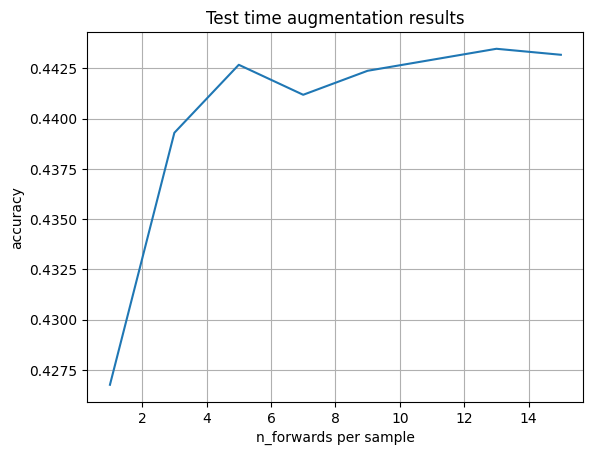

In [27]:
# model_vgg_like deeper with scheduler and pooling LPPool2d 

plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Text(0.5, 1.0, 'Test time augmentation results')

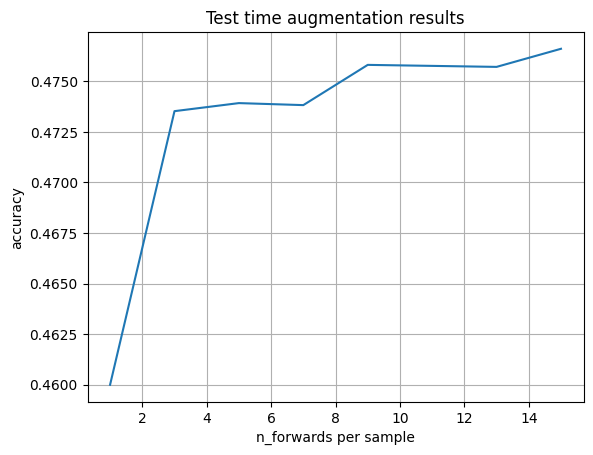

In [27]:
# model_vgg_like not deeper with scheduler and pooling LPPool2d 

plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.

## What's next?
Introducing of residual blocks played a big role in deep learning and allowed to train deep (and I mean really [DEEP](https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua#L2)) networks. Many modern architectures include such layer or its variation. For deeper understanding of influence of skip connections you can read the following papers:
1. ["Residual Networks Behave Like Ensembles of
Relatively Shallow Networks"](https://arxiv.org/pdf/1605.06431.pdf) - interesting point of view on residual blocks showing that statement "skip connections solves vanishing gradients problem" is ambigious in some way
2. ["Identity Mappings in Deep Residual Networks"](https://arxiv.org/pdf/1603.05027.pdf) ([short summary](https://towardsdatascience.com/resnet-with-identity-mapping-over-1000-layers-reached-image-classification-bb50a42af03e)) - study and comparison of different residual blocks variations showing that preserving "identity path" through the network improves quality
3. ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf) - some attempts on loss function visualization showed how skip-connections affect loss landscape